In [20]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt

# **SODA Implementation - Simulation**

Assume we applied a learning algorithm, as described in the notebook **intro_learning**, and stored the result.
Now we want to evaluate the computed strategy and compare it for instance to the continouos solution.
Strategies are for instance solved if we run the *main.py* file (with learning=True, save_strat=True)

## **Create Setting and import strategy**

In [21]:
# Assume we ran the learning algorithm for the following setting using the main.py file
# The computed strategy can be found in experiment/test/strategies
path_config = "configs/"
path_exp = "experiment/test/"

# setting
mechanism_type = "single_item"
experiment = "fpsb"
learn_alg = "frank_wolfe"

In [22]:
from src.util.config import Config

First we have to create the setting, in which we want to evaluate our strategy:

In [23]:
conf = Config()
conf.get_path(path_config)
game, learner = conf.create_setting(mechanism_type, experiment, learn_alg)

Then we create the strategies and import the stored computed ones:

In [24]:
# init strategies
strategies = conf.create_strategies(game)
name = f"{learn_alg}_{experiment}_run_{0}"
for i in strategies:
    strategies[i].load(name, mechanism_type, path_exp)

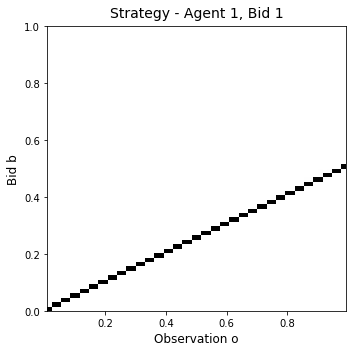

In [25]:
strategies['1'].plot()

## **Sample Bids**

Since we want to evaluate the computed strategy in the original continuous mechanism, we sample bids for evaluation

In [26]:
# sample 100 (continuous) observations for all agents
observation_profile = game.mechanism.sample_types(n_vals = 100)

# sample bids from strategy for first agent (index 0)
observations = observation_profile[0]
bids = strategies['1'].sample_bids(observation=observations)

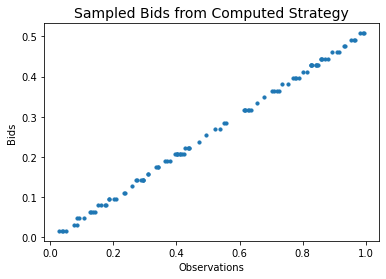

In [36]:
plt.scatter(observations, bids, s = 10)
plt.title("Sampled Bids from Computed Strategy", fontsize=14)
plt.xlabel("Observations")
plt.ylabel("Bids")
plt.show()

We sample continuous observations, identify the nearest discrete observation and then sample discrete bids according to the computed strategy.
This is why we only get discrete actions.

### **Metrics**

One metric we often consider is the approximated L2 distance between the bids from the exact BNE $\beta$ and the bids from the computed strategy $s$

\begin{equation}
    L_2(s, \beta) = \left( \dfrac{1}{n_o} \sum_o ( \beta(o) - s(o))^2 \right)^{\frac 1 2}
\end{equation}

This means we sample many observations (types) and then compute the distance between the equilibrium bid, i.e., $\beta(o)$ and the bid sampled from the computed strategy s, i.e., $b \sim s(\cdot \vert o)$, given the observation o.

In [46]:
obs_profile = game.mechanism.sample_types(n_vals = 1000)
obs = obs_profile[0]
bids = strategies['1'].sample_bids(obs)

game.mechanism.compute_l2_norm(agent='1', obs=obs, bids=bids)

0.007829602091781332

The second import metric is the relative utility loss, i.e., the relative loss in the utility if we play many auctions and use the computed strategy vs. the exact equilibrium strategies. The auctions are simulated by sampling observations and the corresping bids.

In [47]:
game.mechanism.compute_utility(agent='1', obs_profile=obs_profile, bids=bids)

(0.006851931134381206, 0.1747208773906792, 0.17592631236774867)

The last entry is the utility agent '1' would get, if the agent would use the equilibrium strategy $\beta$ ($U(\beta, \beta$). The second entry is the utility of agent '1' when using the computed strategy $s$ ($u)(s,\beta)$. In both cases the opponents play according to the exact equilibrium strategy $\beta$. The first entry denotes the relative difference in utility ($\mathcal L$) we get by not playing the exact BNE:

\begin{equation}
    \mathcal L(s, \beta) = \dfrac{u(\beta, \beta) - u(s, \beta)}{u(\beta, \beta)}
\end{equation}